In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import filters, feature
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

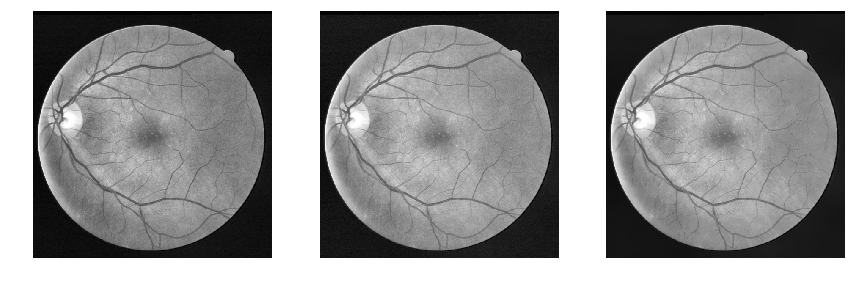

In [43]:
def plot_images(*images):
    images = list(images)
    n = len(images)
    fig, ax = plt.subplots(ncols=n, sharey=True)
    fig.set_size_inches(12,4)
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
    plt.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97)
    plt.show()

img = cv2.imread('data/DRIVE/training/images/21_training.tif')
mask = plt.imread('data/DRIVE/training/mask/21_training_mask.gif') #cause cv2 can't read gifs :X
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
hist_eq = clahe.apply(gray)

gamma = 1.2
# build a lookup table mapping the pixel values [0, 255] to
# their adjusted gamma values
invGamma = 1.0 / gamma
table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
# apply gamma correction using the lookup table
gamma_corrected = cv2.LUT(hist_eq, table)

# fast cv2 denoising
denoised = cv2.fastNlMeansDenoising(gamma_corrected.astype('uint8'), None, 3, 7)
plot_images(hist_eq, gamma_corrected, denoised)

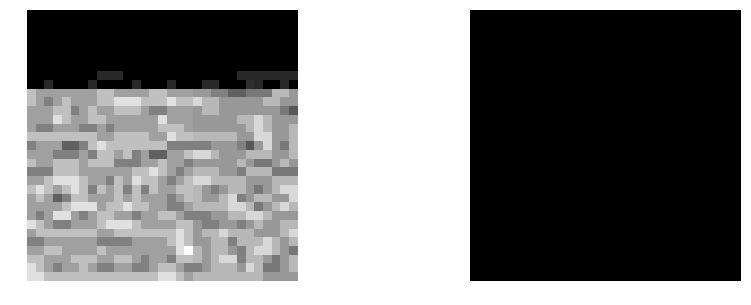

(295302, 31, 31)
(295302,)


In [3]:
def extract_patches(img, patch_size):
    assert(patch_size % 2 == 1)
    patches = []
    for i in range(0, img.shape[0] - patch_size):
        for j in range(0, img.shape[1] - patch_size):
            patches.append(img[i:i + patch_size,j:j+patch_size])
    return patches

extracted = extract_patches(gamma_corrected, 31)
labeled = plt.imread('data/DRIVE/training/1st_manual/21_manual1.gif')
labeled_extracted = extract_patches(labeled, 31)
plot_images(extracted[100],labeled_extracted[100])
X_train = np.asarray(extracted) / 255
y_train = []
for i in labeled_extracted:
    y_train.append((int)(i[15,15] / 255))
y_train = np.asarray(y_train)

print(X_train.shape)
print(y_train.shape)

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(31,31,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

Using TensorFlow backend.


In [5]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
X_train = X_train.reshape(295302,31,31,1)

#model.fit(X_train, y_train, validation_data=(X_train[:30], y_train[:30]), epochs=10)
model.fit(X_train, y_train, validation_data=(X_train, y_train), epochs=1)

Train on 295302 samples, validate on 295302 samples
Epoch 1/1
295302/295302 [==============================] - 618s 2ms/step - loss: 0.1190 - acc: 0.9599 - val_loss: 0.0904 - val_acc: 0.9668


In [7]:
model.save_weights('simple.h5')

In [9]:
prediction = model.predict(X_train)

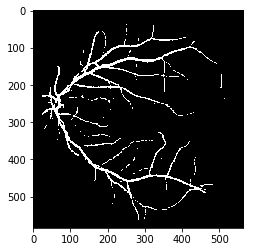

In [42]:
def draw_prediction(prediction):
    prediction[prediction < 0.5] = 0
    prediction[prediction >= 0.5] = 1
    reshaped = prediction.reshape(553,534)
    original_sized = np.zeros((584, 565))
    original_sized[15:568, 15:549] = reshaped
    plt.imshow(original_sized, cmap='gray')

draw_prediction(prediction)